##Histogram:

You need to plot a  histogram for a chosen picture. For this purpose:

- take any picture -> grayscale it -> calculate the histogram for the picture using CUDA (10 points)

- plot the resulting histogram using anything you want (10 points)

For grayscaling and plotting I used python tools, all other were written in C with CUDA implementation

In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import scipy as sp
import pandas as pd
import csv

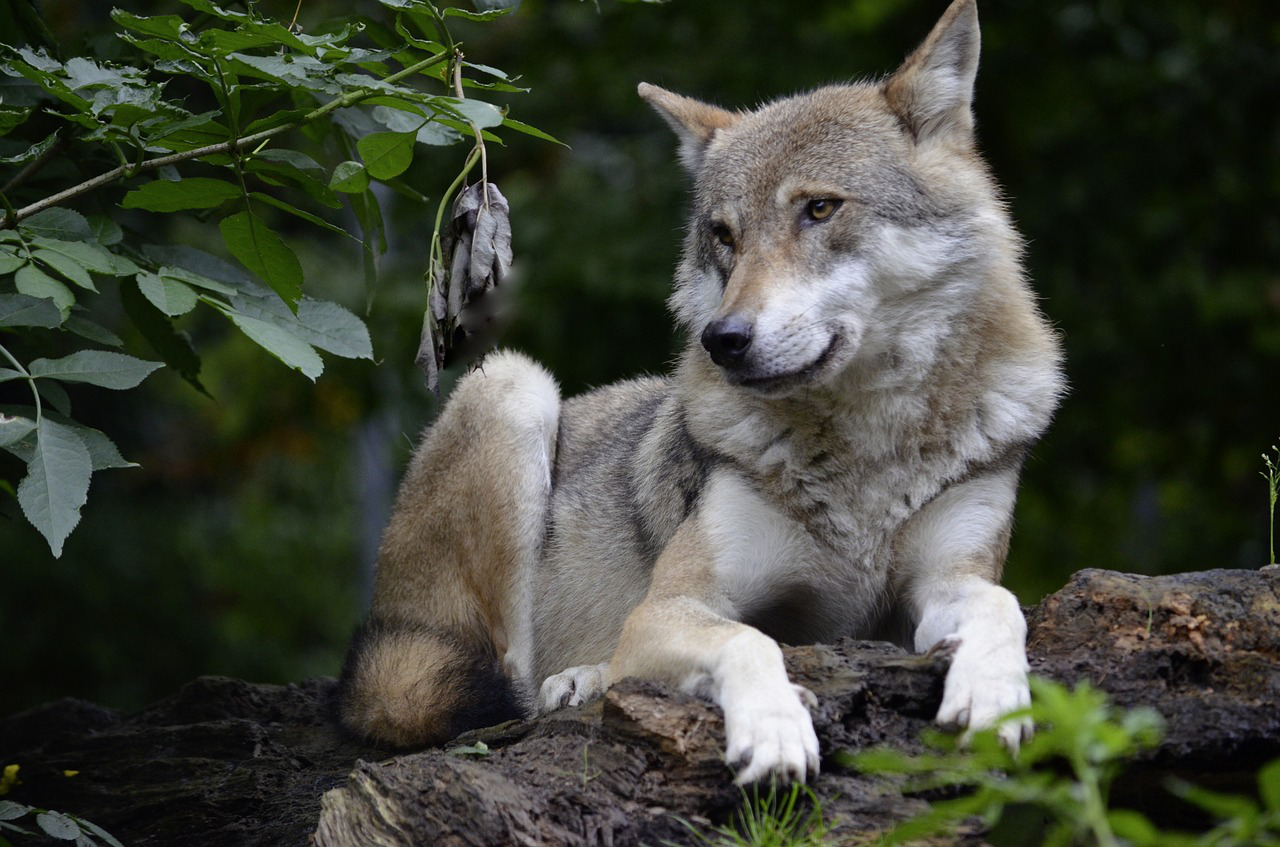

In [2]:
img = Image.open("wolf.jpg")
img

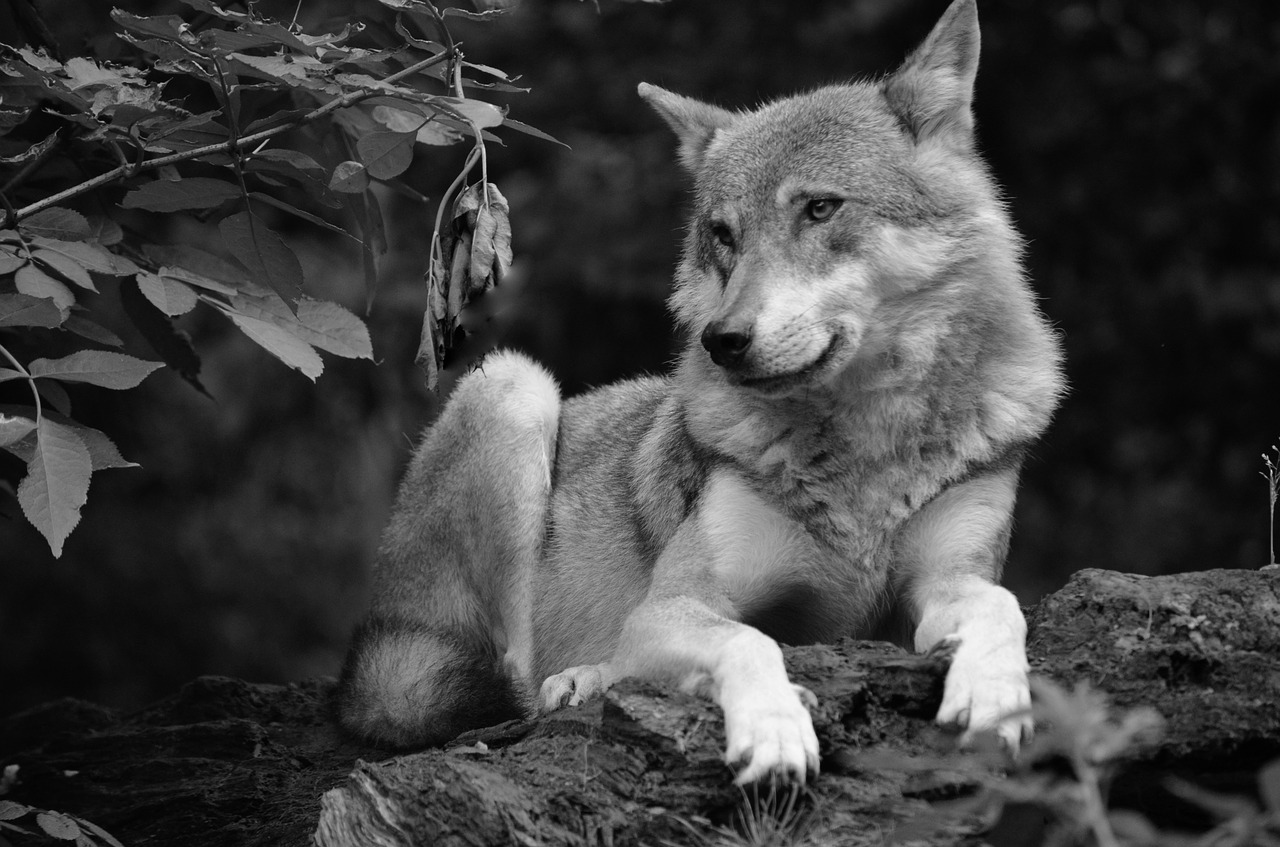

In [3]:
img = ImageOps.grayscale(img)
img.save('gray_wolf.jpg')
img

In [4]:
from matplotlib.image import imread

imgage = img.resize((600, 600), Image.ANTIALIAS)

image  = imread("gray_wolf.jpg") 

In [5]:
with open('greysacaleimage.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=" ")
    [writer.writerow(r) for r in image]

In [6]:
%%writefile Histogram.cu
#include <stdio.h>

__global__ void Init(int n, int *d_hist)
{
    int globalIdx = blockIdx.x * blockDim.x + threadIdx.x;
    if(globalIdx < n) d_hist[globalIdx] = 0;
}

__global__ void Histogram(int *d_hist, int *d_image, long int i)
{
    long int idx = blockIdx.x * blockDim.x + threadIdx.x;
    //printf("hist:%d\n", blockIdx.x);//, blockDim.x, threadIdx.x);
    int tmp;

    tmp = d_image[idx];
    atomicAdd(&(d_hist[tmp]), 1);
    __syncthreads();
}

int main(int ac, char **av)
{
    int height = 847;
    int width = 1280;
 
    int *h_image = (int*)malloc(sizeof(int) * height * width);
    int *h_hist = (int *)malloc(sizeof(int)*256);

 
    FILE *fp;
    int ch;
    fp = fopen("greysacaleimage.csv", "r");
    long int i = 0;
    int tmp = 0;
    while (!feof(fp) && !ferror(fp))
    {
        ch = getc(fp);
        if (ch != EOF)
        {
            if (ch < 32)
              tmp = 0;
            else if (ch != 32)
            {
                if (tmp == 0) tmp += ch - 48;
                else if (tmp != 0) tmp = tmp * 10 + ch - 48;
            }
            else if(ch == 32)
            {
                h_image[i] = tmp;
                tmp = 0;
                i++;
            }
        }
    }
    printf("\n");
    fclose(fp);

    int *d_image;
    int *d_hist;
  
    cudaMalloc(&d_image, sizeof(int) * height * width);
    cudaMalloc(&d_hist, sizeof(int)*256);

    cudaMemcpy(d_image, h_image, sizeof(int)*width*height, cudaMemcpyHostToDevice);
    cudaMemcpy(d_hist, h_hist, sizeof(int)*256, cudaMemcpyHostToDevice);
 
    Init<<<1, 256>>>(256, d_hist);
    Histogram<<<1058, 1024>>>(d_hist, d_image, i);
 
    cudaMemcpy(h_image, d_image, sizeof(int)*width*height, cudaMemcpyDeviceToHost);
    cudaMemcpy(h_hist, d_hist, sizeof(float)*256, cudaMemcpyDeviceToHost);
    cudaDeviceSynchronize();

    FILE *hist;
    hist = fopen("histogram.csv","w");
    for (int i = 0; i < 256; i++) fprintf(hist, "%d ", h_hist[i]);
 
    free(h_image);
    free(h_hist);
    cudaFree(d_image);
    cudaFree(d_hist);

    return(0);
}

Writing Histogram.cu


In [7]:
!nvcc Histogram.cu -o a.out

In [8]:
!./a.out

In [9]:
hist=[]
with open('histogram.csv','r') as file:
    for line in file:
        for word in line.split():         
            hist.append(int(word))

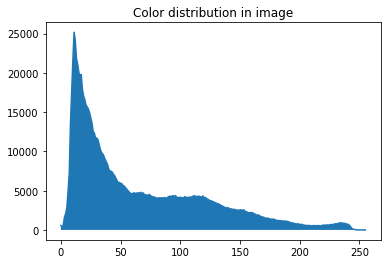

In [10]:
x = np.arange(256)
plt.plot(hist, label='Cuda version')
plt.fill_between(x, 0, hist)
plt.title("Color distribution in image")
plt.show()

In [11]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

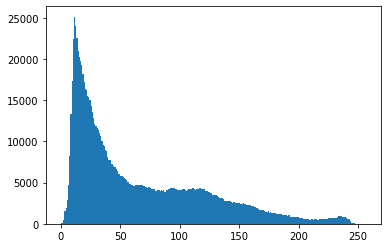

In [12]:
img = cv.imread('wolf.jpg',0)
plt.hist(img.ravel(),256,[0,256])
plt.show()

##Filtering:

Take an arbitrary image and apply two types of filters to it using CUDA.

- Blurring filter (have at least 2 blurring filters - they can differ in stencil size or the values of the filter matrix for example) (15 points)

- Median filter (try to achieve the cartoonish effect) (15 points)

In [13]:
photo = Image.open('wolf.jpg') 
photo = photo.convert('RGB')

width = photo.size[0] 
height = photo.size[1]
R_ = []
G_ = []
B_ = []

for y in range(0, height): 
    row = ""
    for x in range(0, width):
        RGB = photo.getpixel((x,y))
        R, G, B = RGB 
        R_.append(R)
        G_.append(G)
        B_.append(B)

R_ = np.asarray(R_, dtype=np.int32)
G_ = np.asarray(G_, dtype=np.int32)
B_ = np.asarray(B_, dtype=np.int32)

In [14]:
R_ = R_.reshape(1, -1).reshape(1, -1)
G_ = G_.reshape(1, -1).reshape(1, -1)
B_ = B_.reshape(1, -1).reshape(1, -1)

In [15]:
with open('red.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=" ")
    [writer.writerow(r) for r in R_]

In [16]:
with open('green.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=" ")
    [writer.writerow(r) for r in G_]

In [17]:
with open('blue.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=" ")
    [writer.writerow(r) for r in B_]

In [18]:
!cat red.csv

10 10 11 12 12 11 11 9 5 6 6 6 7 9 9 9 8 9 10 12 10 10 10 10 12 12 8 4 0 1 3 5 8 14 17 18 21 24 24 25 29 28 28 31 31 31 32 35 32 33 31 28 27 28 25 21 26 26 27 27 26 26 27 27 26 24 24 26 25 23 23 25 27 25 24 24 22 20 20 22 20 19 18 17 16 16 16 16 15 14 12 12 12 13 12 12 12 12 13 13 12 11 9 10 12 12 13 14 15 15 16 15 13 19 17 13 19 18 12 21 18 18 18 18 18 17 17 17 17 18 18 14 14 14 12 10 12 11 9 9 9 9 11 11 11 11 11 11 11 11 10 8 10 11 11 10 10 11 13 14 19 19 18 18 18 17 18 19 20 20 21 21 24 24 25 26 27 26 29 38 48 53 51 51 52 48 47 47 44 40 40 43 45 51 51 46 46 47 50 53 55 54 53 50 47 46 52 56 53 38 14 10 19 16 18 23 22 20 23 25 23 17 17 21 19 18 16 14 13 12 11 11 10 10 8 7 6 8 7 4 3 4 7 10 17 28 33 35 33 31 22 26 27 26 27 34 36 53 58 40 24 23 26 27 24 24 24 24 25 26 26 25 23 22 21 22 23 22 23 24 22 24 24 21 20 20 19 18 19 15 11 11 14 18 17 13 8 11 17 52 109 58 22 13 23 22 22 25 25 24 25 27 27 28 29 31 31 31 33 36 35 36 38 39 39 37 36 35 35 34 34 34 35 32 29 27 30 31 32 32 30 28 29 31 3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
%%writefile BlurringFilter.cu

# include <time.h>
# include <stdlib.h>
# include <stdio.h>
# include <string.h>
# include <math.h>
# include <cuda.h>

__global__ 
void d_blur(int*arr, int *result, int width, int height) 
{
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  int row = blockIdx.y * blockDim.y + threadIdx.y;
 
  if (row < 2 || col < 2 || row >= height - 3 || col >= width - 3)
    return ;
  int mask [3][3] = {1, 2, 1, 2, 3, 2, 1, 2, 1};
  int sum = 0;
  for (int j= -1; j <= 1; j++)
  {
    for (int i= -1; i <=1; i++)
    {
      int color = arr [( row + j) * width + (col + i)];
      sum += color * mask [i +1][ j +1];
    }
  }
  result [row * width + col] = sum/15;
}

int main (int argc , char **argv)
{
  int height = 847;
  int width = 1280;
  int *h_red = (int*)malloc(sizeof(int) * height * width);
  int *h_green = (int*)malloc(sizeof(int) * height * width);
  int *h_blue = (int*)malloc(sizeof(int) * height * width);
  int *d_red;
  int *d_green;
  int *d_blue;
  int *d_res_red;
  int *d_res_green;
  int *d_res_blue;
 
  cudaMalloc(&d_red, sizeof(int) * height * width);
  cudaMalloc(&d_green, sizeof(int) * height * width);
  cudaMalloc(&d_blue, sizeof(int) * height * width);
 
  cudaMalloc(&d_res_red, sizeof(int) * height * width);
  cudaMalloc(&d_res_green, sizeof(int) * height * width);
  cudaMalloc(&d_res_blue, sizeof(int) * height * width);

  FILE *fp;
  int ch;
  long int tmp;
  long int i = 0;
 
  fp = fopen("red.csv", "r");
  while (!feof(fp) && !ferror(fp))
  {
      ch = getc(fp);
      if (ch != EOF)
      {
          if (ch < 32)
            tmp = 0;
          else if (ch != 32)
          {
              if (tmp == 0) tmp += ch - 48;
              else if (tmp != 0) tmp = tmp * 10 + ch - 48;
          }
          else if (ch == 32)
          {
              h_red[i] = tmp;
              tmp = 0;
              i++;
          }
      }
  }
 
  i = 0;
  fp = fopen("green.csv", "r");
  while (!feof(fp) && !ferror(fp))
  {
      ch = getc(fp);
      if (ch != EOF)
      {
          if (ch < 32)
            tmp = 0;
          else if (ch != 32)
          {
              if (tmp == 0) tmp += ch - 48;
              else if (tmp != 0) tmp = tmp * 10 + ch - 48;
          }
          else if (ch == 32)
          {
              h_green[i] = tmp;
              tmp = 0;
              i++;
          }
      }
  }
 
  i = 0;
  fp = fopen("blue.csv", "r");
  while (!feof(fp) && !ferror(fp))
  {
      ch = getc(fp);
      if (ch != EOF)
      {
          if (ch < 32)
            tmp = 0;
          else if (ch != 32)
          {
              if (tmp == 0) tmp += ch - 48;
              else if (tmp != 0) tmp = tmp * 10 + ch - 48;
          }
          else if(ch == 32)
          {
              h_blue[i] = tmp;
              tmp = 0;
              i++;
          }
      }
  }
 
  h_red[0] = 10; //cannot fix bug
 
  cudaMemcpy(d_red, h_red, sizeof(int)*width*height, cudaMemcpyHostToDevice);
  cudaMemcpy(d_green, h_green, sizeof(int)*width*height, cudaMemcpyHostToDevice);
  cudaMemcpy(d_blue, h_blue, sizeof(int)*width*height, cudaMemcpyHostToDevice);
  
  dim3 block (16, 16);
  dim3 grid (width/16, height/16);
  
  d_blur <<<grid, block>>>(d_red, d_res_red, width, height);
  d_blur <<<grid, block>>>(d_green, d_res_green, width, height);
  d_blur <<<grid, block>>>(d_blue, d_res_blue, width, height);
  cudaDeviceSynchronize();
 
  cudaMemcpy(h_red, d_res_red, sizeof(int)*width*height, cudaMemcpyDeviceToHost);
  cudaMemcpy(h_green, d_res_green, sizeof(int)*width*height, cudaMemcpyDeviceToHost);
  cudaMemcpy(h_blue, d_res_blue, sizeof(int)*width*height, cudaMemcpyDeviceToHost);
 
  FILE *r, *g, *b;
 
  r = fopen("res_red.csv","w");
  for (int i = 0; i < height*width; i++) fprintf(r, "%d ", h_red[i]);
 
  g = fopen("res_green.csv","w");
  for (int i = 0; i < height*width; i++) fprintf(g, "%d ", h_green[i]);
 
  b = fopen("res_blue.csv","w");
  for (int i = 0; i < height*width; i++) fprintf(b, "%d ", h_blue[i]);
 

  free(h_red);
  free(h_green);
  free(h_blue);
  cudaFree(d_red);
  cudaFree(d_res_red);
  cudaFree(d_green);
  cudaFree(d_res_green);
  cudaFree(d_blue);
  cudaFree(d_res_blue);

  return(0);
}

Writing BlurringFilter.cu


In [20]:
!nvcc BlurringFilter.cu -o a.out

In [21]:
 !./a.out

In [22]:
red=[]
green = []
blue = []

with open('res_red.csv','r') as file:
    for line in file:
        for word in line.split():         
            red.append(int(word))

with open('res_green.csv','r') as file:
    for line in file:
        for word in line.split():         
            green.append(int(word))

with open('res_blue.csv','r') as file:
    for line in file:
        for word in line.split():         
            blue.append(int(word))

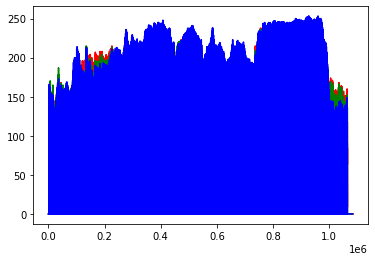

In [23]:
x = np.arange(256)
plt.plot(red, label='red', color='r')
plt.plot(green, label='green', color='g')
plt.plot(blue, label='blue', color='b')
plt.show()

In [24]:
red_ = np.zeros((847, 1280))
green_ = np.zeros((847, 1280))
blue_ = np.zeros((847, 1280))
blurred = np.zeros((847, 1280))
blurred = Image.fromarray(np.uint8(blurred)).convert('RGB')

In [25]:
n = 0
for i in range(847):
  for j in range(1280):
    blurred.putpixel((j, i), (red[n], green[n], blue[n])) 
    n += 1



for n in range(847*1280):
  j = n%1280
  i = n//1280
  blurred.putpixel((j, i), (red[n], green[n], blue[n]))

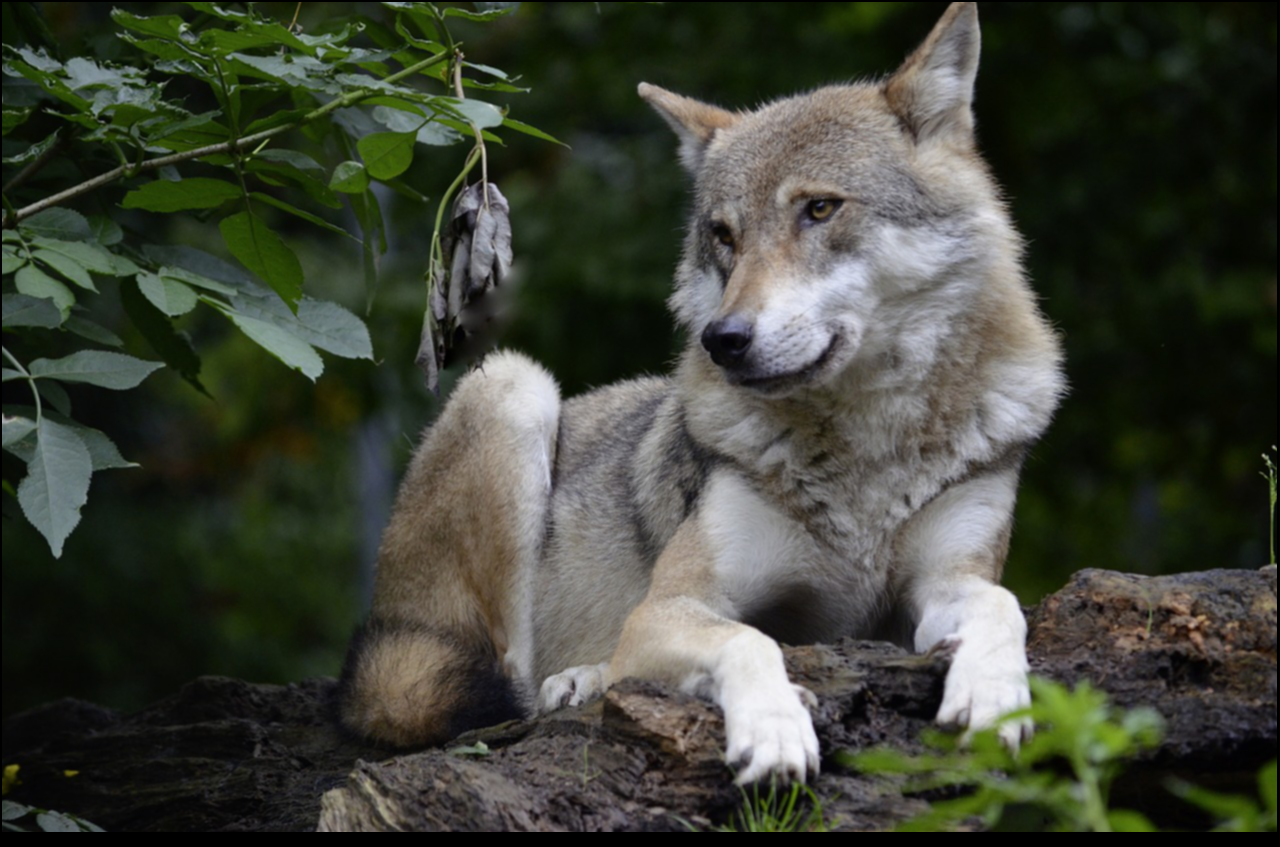

In [26]:
blurred

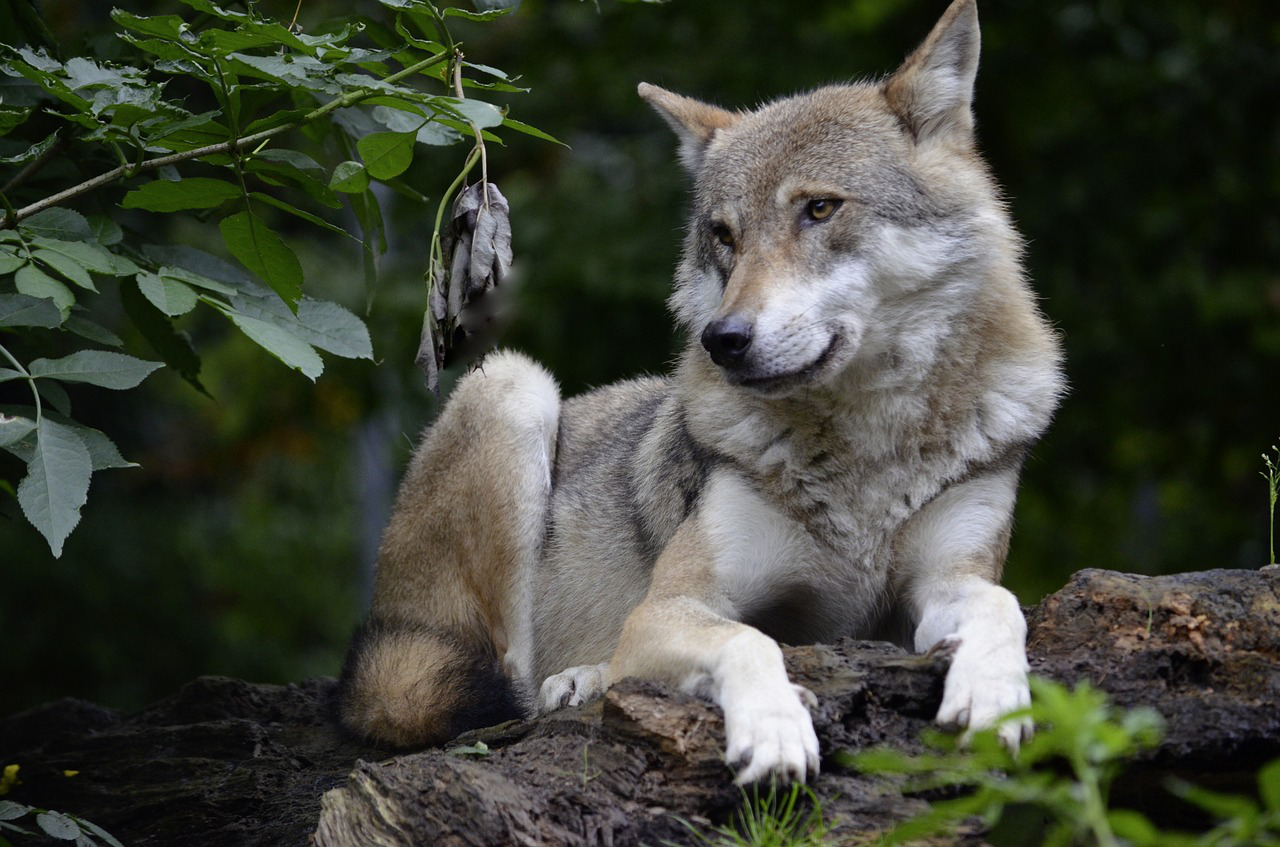

In [27]:
photo

In [28]:
10 + 10 + 17 + 10 + 10

57

In [29]:
%%writefile Filter.cu

# include <time.h>
# include <stdlib.h>
# include <stdio.h>
# include <string.h>
# include <math.h>
# include <cuda.h>

__global__ 
void d_blur(int*arr, int *result, int width, int height) 
{
  int col = blockIdx.x * blockDim.x + threadIdx.x;
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  if (row < 2 || col < 2 || row >= height-3 || col >= width-3)
    return ;
  int mask [3][3] = {0, 10, 0, 10, 17, 10, 0, 10, 0};
  int sum = 0;
  for (int j= -1; j <=1; j++)
  {
    for (int i= -1; i <=1; i++)
    {
      int color = arr [(row + j) * width + (col + i)];
      sum += color * mask [i+1][j+1];
    }
  }
  result [row * width + col] = sum/57;
}

int main (int argc , char **argv)
{
  int height = 847;
  int width = 1280;
  int *h_red = (int*)malloc(sizeof(int) * height * width);
  int *h_green = (int*)malloc(sizeof(int) * height * width);
  int *h_blue = (int*)malloc(sizeof(int) * height * width);
  int *d_red;
  int *d_green;
  int *d_blue;
  int *d_res_red;
  int *d_res_green;
  int *d_res_blue;
 
  cudaMalloc(&d_red, sizeof(int) * height * width);
  cudaMalloc(&d_green, sizeof(int) * height * width);
  cudaMalloc(&d_blue, sizeof(int) * height * width);
 
  cudaMalloc(&d_res_red, sizeof(int) * height * width);
  cudaMalloc(&d_res_green, sizeof(int) * height * width);
  cudaMalloc(&d_res_blue, sizeof(int) * height * width);

  FILE *fp;
  int ch;
  long int tmp;
  long int i = 0;
 
  fp = fopen("red.csv", "r");
  while (!feof(fp) && !ferror(fp))
  {
      ch = getc(fp);
      if (ch != EOF)
      {
          if (ch < 32)
            tmp = 0;
          else if (ch != 32)
          {
              if (tmp == 0) tmp += ch - 48;
              else if (tmp != 0) tmp = tmp * 10 + ch - 48;
          }
          else if (ch == 32)
          {
              h_red[i] = tmp;
              tmp = 0;
              i++;
          }
      }
  }
 
  i = 0;
  fp = fopen("green.csv", "r");
  while (!feof(fp) && !ferror(fp))
  {
      ch = getc(fp);
      if (ch != EOF)
      {
          if (ch < 32)
            tmp = 0;
          else if (ch != 32)
          {
              if (tmp == 0) tmp += ch - 48;
              else if (tmp != 0) tmp = tmp * 10 + ch - 48;
          }
          else if (ch == 32)
          {
              h_green[i] = tmp;
              tmp = 0;
              i++;
          }
      }
  }
 
  i = 0;
  fp = fopen("blue.csv", "r");
  while (!feof(fp) && !ferror(fp))
  {
      ch = getc(fp);
      if (ch != EOF)
      {
          if (ch < 32)
            tmp = 0;
          else if (ch != 32)
          {
              if (tmp == 0) tmp += ch - 48;
              else if (tmp != 0) tmp = tmp * 10 + ch - 48;
          }
          else if(ch == 32)
          {
              h_blue[i] = tmp;
              tmp = 0;
              i++;
          }
      }
  }
 
  h_red[0] = 10; //cannot fix bug
 
  cudaMemcpy(d_red, h_red, sizeof(int)*width*height, cudaMemcpyHostToDevice);
  cudaMemcpy(d_green, h_green, sizeof(int)*width*height, cudaMemcpyHostToDevice);
  cudaMemcpy(d_blue, h_blue, sizeof(int)*width*height, cudaMemcpyHostToDevice);
  
  dim3 block (16 ,16);
  dim3 grid (width/16 , height/16);
  
  d_blur <<<grid, block>>>(d_red, d_res_red, width, height);
  d_blur <<<grid, block>>>(d_green, d_res_green, width, height);
  d_blur <<<grid, block>>>(d_blue, d_res_blue, width, height);
  cudaDeviceSynchronize();
 
  cudaMemcpy(h_red, d_res_red, sizeof(int)*width*height, cudaMemcpyDeviceToHost);
  cudaMemcpy(h_green, d_res_green, sizeof(int)*width*height, cudaMemcpyDeviceToHost);
  cudaMemcpy(h_blue, d_res_blue, sizeof(int)*width*height, cudaMemcpyDeviceToHost);

  FILE *r, *g, *b;
 
  r = fopen("res_red.csv","w");
  for (int i = 0; i < height*width; i++) fprintf(r, "%d ", h_red[i]);
 
  g = fopen("res_green.csv","w");
  for (int i = 0; i < height*width; i++) fprintf(g, "%d ", h_green[i]);
 
  b = fopen("res_blue.csv","w");
  for (int i = 0; i < height*width; i++) fprintf(b, "%d ", h_blue[i]);

  free(h_red);
  free(h_green);
  free(h_blue);
  cudaFree(d_red);
  cudaFree(d_res_red);
  cudaFree(d_green);
  cudaFree(d_res_green);
  cudaFree(d_blue);
  cudaFree(d_res_blue);

  return(0);
  
}

Writing Filter.cu


In [30]:
!nvcc Filter.cu -o a.out

In [31]:
!./a.out

In [32]:
red=[]
green = []
blue = []

with open('res_red.csv','r') as file:
    for line in file:
        for word in line.split():         
            red.append(int(word))

with open('res_green.csv','r') as file:
    for line in file:
        for word in line.split():         
            green.append(int(word))

with open('res_blue.csv','r') as file:
    for line in file:
        for word in line.split():         
            blue.append(int(word))

In [33]:
red_ = np.zeros((847, 1280))
green_ = np.zeros((847, 1280))
blue_ = np.zeros((847, 1280))
blurred = np.zeros((847, 1280))
blurred = Image.fromarray(np.uint8(blurred)).convert('RGB')

In [34]:
n = 0
for i in range(847):
  for j in range(1280):
    blurred.putpixel((j, i), (red[n]//2, green[n], blue[n]//4)) 
    n += 1

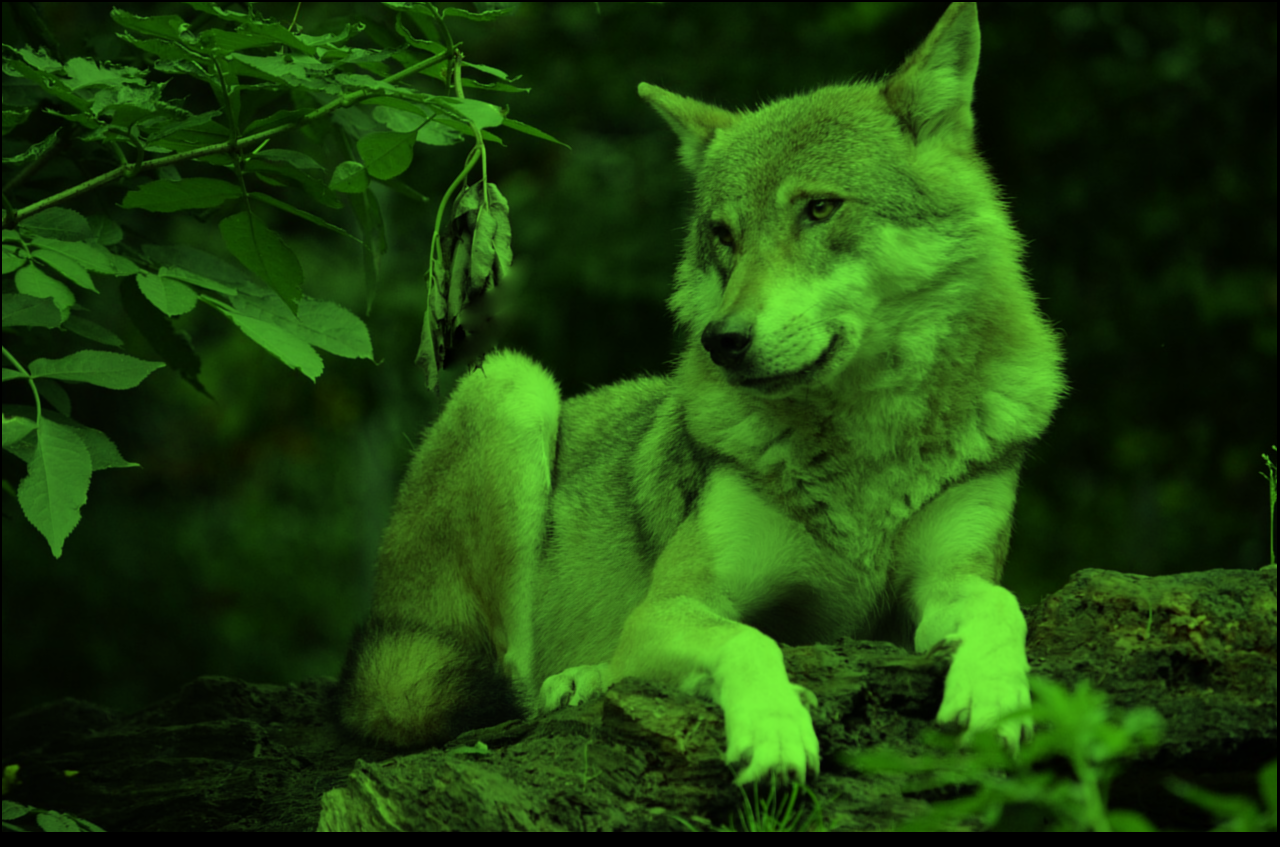

In [35]:
blurred

##Laplace equation:  

- solve the Laplace equation using CUDA. (10 points)

- draw the heatmap of the solution u(x,y) using anything you want (10 points)


In [114]:
%%writefile Laplace.cu
#include <stdio.h>

const int N = 50;

__global__
void Init(long int n, float *d_a)
{
    int globalIdx = blockIdx.x * blockDim.x + threadIdx.x;

    if(globalIdx < n)
    { 
        if (blockIdx.x != 0) d_a[globalIdx] = 0;
        else 
        {
            if ((threadIdx.x == 0) | (threadIdx.x == N-1)) d_a[globalIdx] = 0;
            else d_a[globalIdx] = 1;
        }
    }  
}

__global__
void Step(long int n, float *d_old, float *d_new)
{
    int globalIdx = blockIdx.x * blockDim.x + threadIdx.x;
    int up, down, right, left;

    if(globalIdx < n)
    { 
        //printf("dim %d, block %d, thread %d\n", blockDim.x, blockIdx.x, threadIdx.x);
        if((blockIdx.x != 0) && (blockIdx.x !=  N-1))
        {
            if((threadIdx.x != 0) && (threadIdx.x !=  N-1))
            {
                right = (blockIdx.x + 1) * blockDim.x + threadIdx.x;
                left = (blockIdx.x - 1) * blockDim.x + threadIdx.x;
             
                up = blockIdx.x * blockDim.x + threadIdx.x + 1;
                down = blockIdx.x * blockDim.x + threadIdx.x - 1;
             
                d_new[globalIdx] = (d_old[up] + d_old[down] + d_old[right] + d_old[left])/0.002;
                d_old[globalIdx] = d_new[globalIdx];
            }
        }
    }  
}

int main()
{
    float *d_old;
    float *d_map;

    cudaMallocManaged(&d_old, sizeof(float)*N*N);
    cudaMallocManaged(&d_map, sizeof(float)*N*N);

    Init<<<N,N>>>(N*N, d_old);
    Init<<<N,N>>>(N*N, d_map);

    for(int step = 0; step < 10; step++) 
    {
        if (step % 10 == 0) cudaDeviceSynchronize();
        Step<<<N,N>>>(N*N, d_old, d_map);   
    }

    cudaDeviceSynchronize();

    FILE *fp;
    fp = fopen("heatmap.txt","w");

    for (int j=0; j < N; j++)
    {
        for (int i=0; i < N; i++)
        {
            fprintf(fp, "%f ", d_map[i + j * N]);
        }
        fprintf(fp, "\n");
    }

    cudaDeviceSynchronize();
 
    fclose(fp);
    cudaFree(d_old);
    cudaFree(d_map);

    return 0;
}

Overwriting Laplace.cu


In [115]:
!nvcc Laplace.cu -o a.out

In [116]:
!./a.out

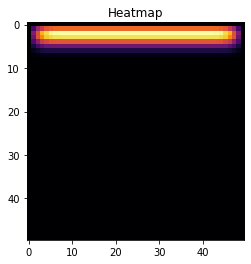

In [117]:
with open("heatmap.txt", 'r') as file:
    heatmap = pd.DataFrame(np.genfromtxt(file, skip_header=0))
heatmap  = np.array(heatmap )
plt.imshow(heatmap, cmap='inferno')
plt.title('Heatmap')
plt.show()